## Manhattan and QQ_plot

In [ ]:
[global]
# the output directory for generated files
parameter: cwd = path
# Path to sample file
parameter: sampleFile = path('.')
# Genotype files in plink binary this is used for computing the GRM
parameter: bfile = path
# Path to bgen or bed files 
parameter: genoFile = paths
# Phenotype file for quantitative trait (BMI)
parameter: phenoFile = path
# Phenotype to be analyzed (specify the column)
parameter: phenoCol = list
# Summary stats file to use
paramter: sumstats_file = path
# Specific number of threads to use
parameter: numThreads = 2
# For cluster jobs, number commands to run per job
parameter: job_size = 1
# The container with the lmm software. Can be either a dockerhub image or a singularity `sif` file.
# Default is set to using dockerhub image
parameter: container_lmm = 'statisticalgenetics/lmm:2.4'
parameter: container_marp = 'gaow/marp'

In [ ]:
# Manhattan and QQ plots using `qqman`
[default]
# Column name for BP
parameter: bp = 'POS'
# Column name for p-value
parameter: pval = 'P'
# Column name for SNP
parameter: snp = 'SNP'
# Plot only on p-values smaller than this
parameter: p_filter = '0.05'
# ylim set to 0 to use maximum -log10(p) in data
parameter: ylim = 0
sep = '\n\n---\n'
depends: phenoFile
input: f'{cwd}/{sumstats_file}'
output: manhattan = f'{_input[0]:nn}.manhattan.png',
        qq = f'{_input[0]:nn}.qq.png',
        analysis_summary = f'{_input[0]:nn}.analysis_summary.md',     
task: trunk_workers = 1, trunk_size = job_size, walltime = '3h', mem = '48G', tags = f'{step_name}_{_output[0]:bn}'    
bash: container=container_lmm, expand = "${ }"
    echo '''---
    theme: base-theme
    style: |
      img {
        height: 80%;
        display: block;
        margin-left: auto;
        margin-right: auto;
      }
    ---    
    ''' > ${_output[2]}
    
R: container=container_lmm, expand='${ }', stderr = f'{_output[0]:n}.stderr', stdout = f'{_output[0]:n}.stdout'
    # some summary statistics for phenotype
    pheno = read.table(${phenoFile:r}, header=T, sep = "")$${_phenoCol}
    if (length(unique(pheno))>2) {
      out = capture.output(summary(pheno))
    } else {
      out = as.data.frame(table(pheno))
      rownames(out) = c('n_ctrl', 'n_case')
      out = out[,2,drop=F]
    }
    write('# ${_phenoCol} result summary\n## Phenotype summary:\n```', ${_output[2]:r}, append = T)
    write.table(out, ${_output[2]:r}, append = T)
    write('${(" Heritability is %s" % heritability) if heritability is not None else ''}', ${_output[2]:r}, append = T)
    write("```", ${_output[2]:r}, append = T)

R: container=container_lmm, expand='${ }', stderr = f'{_output[0]:n}.stderr', stdout = f'{_output[0]:n}.stdout'
    library('qqman')
    data <- read.table(gzfile('${_input}'), sep='\t', header=T)
    lambda <- median(qchisq(1-data$${pval},1), na.rm=TRUE)/qchisq(0.5,1)
    ifelse((${ylim} == 0 && min(data$${pval}, na.rm=TRUE)!=0), ylim <- abs(floor(log10(min(data$${pval}, na.rm=TRUE)))), ylim <- abs(floor(log10(2.225074e-308))))
    # Creating manhattan plot
    png('${_output[0]}', width = 6, height = 4, unit='in', res=300)
    manhattan_plot <- manhattan(data, chr='CHR', bp='${bp}', snp='${snp}', p='${pval}', main = 'Manhattan plot for ${_phenoCol} ', ylim = c(0, ylim), cex = 0.6, 
    cex.axis = 0.9, col = c("blue4", "orange3"), chrlabs = as.character(c(1:22)))
    dev.off()
    # Creating qqplot
    png('${_output[1]}', width = 5, height = 5, unit='in', res=300)
    qq_plot <- qq(data$${pval}, main = 'QQ Plot for ${_phenoCol} ', xlim = c(0, 8), ylim = c(0, ylim), pch = 18, col = "blue4", cex = 1.5, las = 1)
    dev.off()
    write('## p-value summary:', ${_output[2]:r}, append=T)
    write(paste("Genomic inflation factor is", round(lambda,3), "for", nrow(data), "variants analyzed.${sep}"), ${_output[2]:r}, append=T)
    
  
bash: container=container_lmm, expand = True
  set -e
  echo -e "# QQ plot for {_phenoCol}\n" >> {_output[2]}
  echo -e "![]({_output[1]:bn}.png){sep}" >> {_output[2]}
  echo -e "# Manhattan plot for {_phenoCol}\n" >> {_output[2]}
  echo -e "![]({_output[0]:bn}.png){sep}" >> {_output[2]}
  echo -e "# Manhattan plot for {_phenoCol}\n" >> {_output[2]}
  echo -e "\`\`\`" >> {_output[3]}

In [1]:
library('qqman')

/home/dmc2245/miniconda3/lib/python3.8/site-packages/sos_notebook/kernel.py:1334: DeprecationWarning: Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  msg['msg_id'] = self._parent_header['header']['msg_id']


In [2]:
data <- read.table(gzfile('/home/dmc2245/UKBiobank/results/REGENIE_results/results_exome_data/mendelian_like_qc_exomes200K/080421_UKBB_Mendelian_expandedwhite_1520cases_98082ctrl_mendelian.regenie.snp_stats_original_columns_mafabove0.01.gz'), sep='\t', header=T) 

In [3]:
head(data)

,CHROM,GENPOS,ID,ALLELE0,ALLELE1,A1FREQ,N,TEST,BETA,SE,CHISQ,LOG10P
,<int>,<int>,<fct>,<fct>,<fct>,<dbl>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,2,43092,chr2:43092:G:A,G,A,0.0145074,87955,ADD,0.00695131,0.1616710,0.00184872,0.0151559
2,2,43210,chr2:43210:A:T,A,T,0.0128588,87955,ADD,-0.05017160,0.1718800,0.08520470,0.1133040
3,2,43362,chr2:43362:G:A,G,A,0.0128247,87955,ADD,-0.05210530,0.1722350,0.09152060,0.1179010
4,2,45895,chr2:45895:A:G,A,G,0.9954640,87954,ADD,-0.51358700,0.2341820,4.15795000,1.3825900
5,2,224919,chr2:224919:A:G,A,G,0.3460630,87523,ADD,0.05777920,0.0410715,1.97907000,0.7972710
6,2,234130,chr2:234130:T:G,T,G,0.3378140,84961,ADD,-0.00906280,0.0428047,0.04482710,0.0797085


In [4]:
library('tidyverse')
maf_5 <- data %>%
    filter(A1FREQ > 0.5)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [5]:
maf_5

CHROM,GENPOS,ID,ALLELE0,ALLELE1,A1FREQ,N,TEST,BETA,SE,CHISQ,LOG10P
<int>,<int>,<fct>,<fct>,<fct>,<dbl>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
2,45895,chr2:45895:A:G,A,G,0.995464,87954,ADD,-0.513587000,0.2341820,4.15795e+00,1.38259000
2,242732,chr2:242732:T:TAAC,T,TAAC,0.653428,87608,ADD,0.058469100,0.0409836,2.03532e+00,0.81337700
2,243567,chr2:243567:T:TA,T,TA,0.691927,86981,ADD,0.070760200,0.0422168,2.80936e+00,1.02819000
2,262553,chr2:262553:T:C,T,C,0.693750,87884,ADD,0.065888700,0.0422178,2.43575e+00,0.92592400
2,264895,chr2:264895:G:C,G,C,0.999960,87816,ADD,1.013370000,4.0608300,6.22736e-02,0.09531810
2,283231,chr2:283231:A:AT,A,AT,0.898408,87950,ADD,0.163853000,0.0685040,5.94603e+00,1.83119000
2,676177,chr2:676177:C:G,C,G,0.739941,87955,ADD,0.013009700,0.0444070,8.58281e-02,0.11376400
2,676478,chr2:676478:T:TGTAA,T,TGTAA,0.836701,86917,ADD,0.062147200,0.0531019,1.36969e+00,0.61642800
2,677213,chr2:677213:G:A,G,A,0.831211,87621,ADD,0.039382900,0.0525263,5.62160e-01,0.34352700


In [8]:
data$pvalue <- 10**-(data$LOG10P)

In [6]:
lambda <- median(qchisq(1-data$pvalue,1), na.rm=TRUE)/qchisq(0.5,1)

In [7]:
lambda

[1] 1.019317

In [9]:
ylim <- abs(floor(log10(min(data$pvalue, na.rm=TRUE)))) 

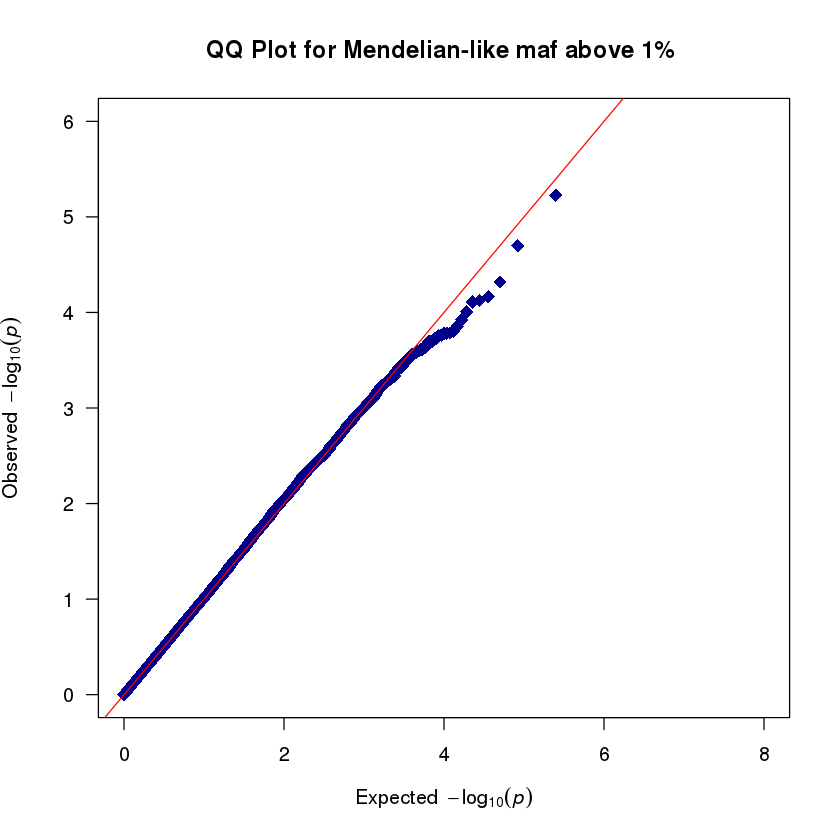

In [13]:
qq_plot <- qq(data$pvalue, main = 'QQ Plot for Mendelian-like maf above 1% ', xlim = c(0, 8), ylim = c(0, ylim), pch = 18, col = "blue4", cex = 1.5, las = 1)

Warning message in manhattan(data, chr = "CHROM", bp = "GENPOS", snp = "ID", p = "pvalue", :
“You're trying to specify chromosome labels but the number of labels != number of chromosomes.”


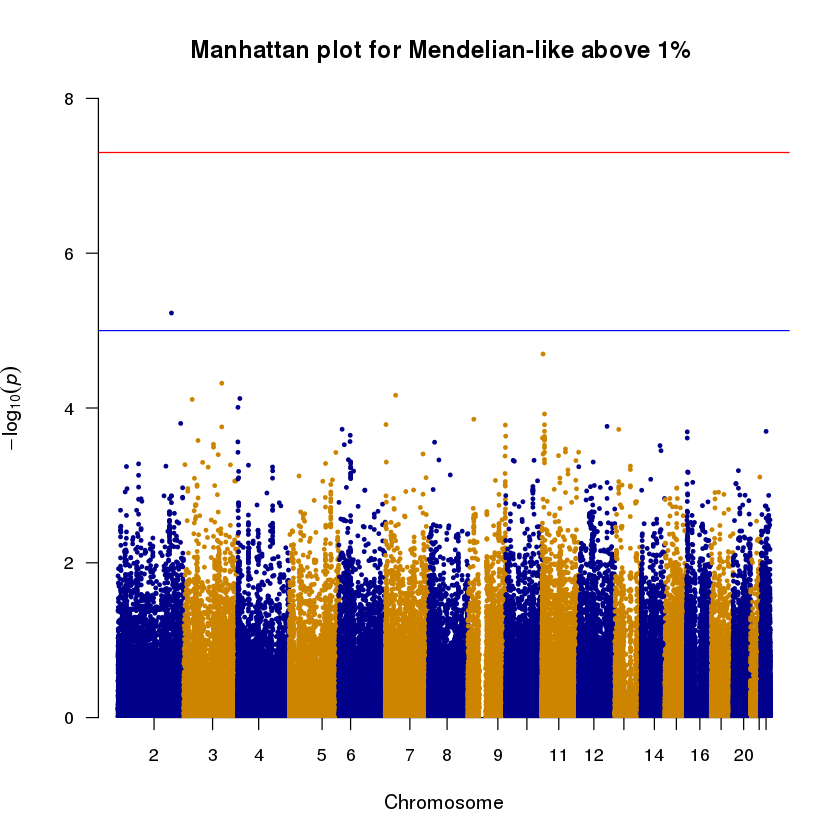

In [11]:
manhattan_plot <- manhattan(data, chr='CHROM', bp='GENPOS', snp='ID', p='pvalue', main = 'Manhattan plot for Mendelian-like above 1% ', ylim = c(0, 8), cex = 0.6, 
    cex.axis = 0.9, col = c("blue4", "orange3"), chrlabs = as.character(c(1:22)))